# PCA and Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.cluster import AgglomerativeClustering

!pip install kneed

# to find elbow point for optimal cluster
from kneed import KneeLocator

import csv



In [ ]:
# Loading the dataset
twitter = pd.read_csv("training_embed.csv")

# PCA - Dimensionality  Reduction

In [ ]:
# Create new dataframe that has the clean text and financial bert embeddings
cluster_df = pd.DataFrame()
cluster_df["clean_text"] = twitter["clean_text"]

# convert embeddings into a numpy array (original uses spaces to seperate)
cluster_df["embeddings"] = twitter["financialBERT_embedding"].apply(
    lambda x: np.array(x.strip("[]").split(), dtype=float)
)

# create single array of all the embeddings
embeddings = np.vstack(cluster_df["embeddings"].values)


In [ ]:
pca = PCA(n_components=150)
reduced_embeddings = pca.fit_transform(embeddings)
print("Reduced PCA embeddings shape: ", reduced_embeddings.shape)

total_variance_explained = np.sum(pca.explained_variance_ratio_)
print("Total variance explained by 100 components:", total_variance_explained)

Reduced PCA embeddings shape:  (9543, 150)
Total variance explained by 100 components: 0.897346201697818


In [ ]:
pca_prop_explained = pca.explained_variance_ratio_

In [ ]:
fig = px.line(
    x=np.arange(1, len(pca_prop_explained) + 1),
    y=pca_prop_explained,
    labels={"x": "Principal Component", "y": "Proportion of Variance Explained"},
    title="Scree Plot of PCA Components"
)

fig.show()

# Finding Optimal K For Clustering

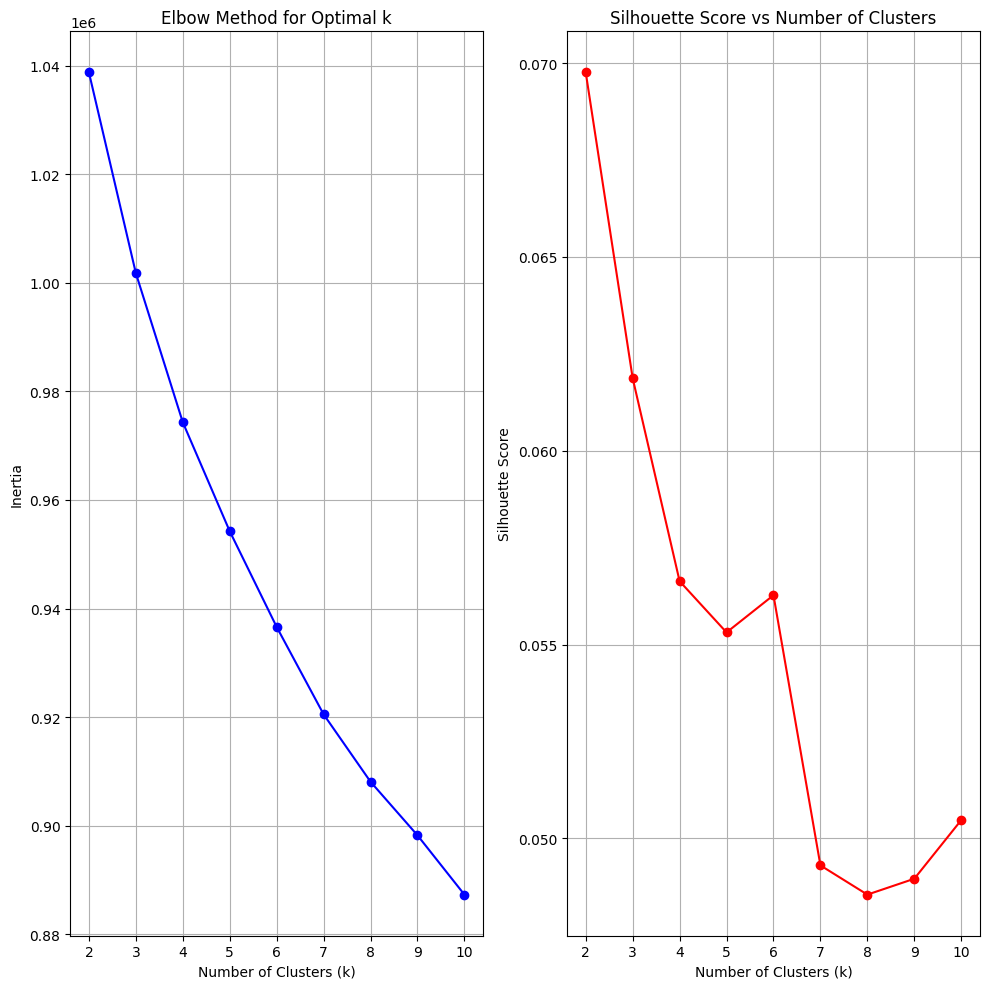

Optimal k (elbow method): 5
Optimal number of clusters: 2


In [ ]:
def find_optimal_clusters(embeddings, max_k = 10):
  inertias = []
  sil_scores = []
  k_range = range(2, max_k + 1)

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
      cluster_labels = kmeans.fit_predict(embeddings)

      inertias.append(kmeans.inertia_)
      sil_scores.append(silhouette_score(embeddings, cluster_labels))

  return k_range, inertias, sil_scores

# Finding the optimal clusters using these metrics
k_range, inertias, silhouette_scores = find_optimal_clusters(reduced_embeddings)

# create a plot that has two plots (left and right)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
# Elbow plot
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find k with elbow point of the inertia curve
knee = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
optimal_k_elbow = knee.knee
print(f"Optimal k (elbow method): {optimal_k_elbow}")

# Find k with highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

In [ ]:

kmeans = KMeans(n_clusters=optimal_k_elbow, random_state = 42, n_init=10)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

cluster_df['kmeans'] = cluster_labels

kmeans.cluster_centers_
cluster_df.head()

,clean_text,embeddings,kmeans
0,jpmorgan reels expectations beyond meat,"[0.335539281, -0.858061671, -0.454550415, -0.0...",2
1,nomura points bookings weakness carnival and r...,"[0.0462081991, -0.772762179, -0.741336942, 0.6...",1
2,cemex cut credit suisse morgan weak building o...,"[0.209908009, -0.875504434, 0.181432471, 0.706...",1
3,btig research cuts neutral,"[0.153301969, -0.837865829, -0.278828889, -0.3...",1
4,funko slides after piper jaffray cut,"[0.6521855, -1.42149413, -0.86564678, -0.17838...",3


In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score

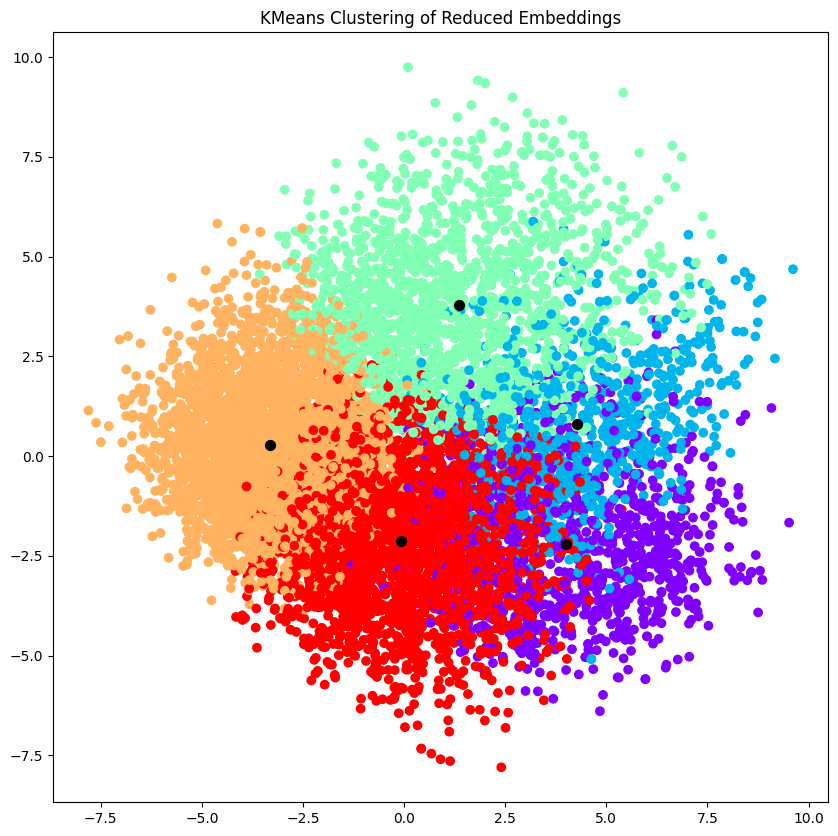

In [ ]:
# visualizing the clusters and cluster centers
centroids = kmeans.cluster_centers_
plt.figure(figsize = (10,10))

plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c = cluster_labels, cmap='rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.title("KMeans Clustering of Reduced Embeddings")

plt.show()


In [ ]:
# who's grouped together
# print("Clustering Results:")
# for cluster_id in sorted(cluster_df['kmeans'].unique()): # go through eahc cluster
#     cluster_texts = cluster_df[cluster_df['kmeans'] == cluster_id]['clean_text'].tolist() # print out the clean text if cluster label matches
#     print(f"\nCluster {cluster_id}:")
#     for i, text in enumerate(cluster_texts, 1):
#         print(f"  {i}. {text}") # print out the tweet

# Hierarchical Clustering

In [ ]:
# hierarchical clustering
hclust = AgglomerativeClustering(n_clusters=optimal_k_elbow, metric='euclidean', linkage='ward')
twitter_hclust_labels = hclust.fit(reduced_embeddings).labels_

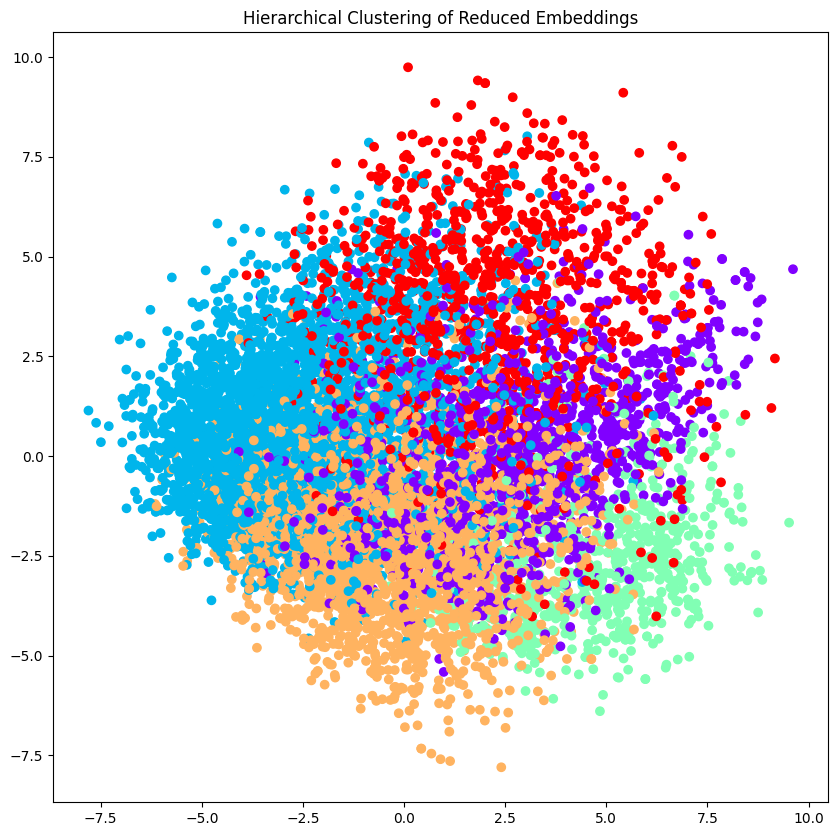

In [ ]:
#Visualize clusters
plt.figure(figsize=(10,10))
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c = twitter_hclust_labels, cmap='rainbow')
plt.title("Hierarchical Clustering of Reduced Embeddings")
plt.show()

In [ ]:

cluster_labels = hclust.fit_predict(reduced_embeddings)

cluster_df['high_cluster'] = cluster_labels
# who's grouped together
# print("Clustering Results:")
# for cluster_id in sorted(cluster_df['high_cluster'].unique()): # go through eahc cluster
#     cluster_texts = cluster_df[cluster_df['high_cluster']== cluster_id]['clean_text'].tolist() # print out the clean text if cluster label matches
#     print(f"\nCluster {cluster_id}:")
#     for i, text in enumerate(cluster_texts, 1):
#         print(f"  {i}. {text}") # print out the tweet

# HDBScan Clustering

#

In [ ]:
# Trying to see if hdbscan is better for clustering
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=15,  # minimum tweets per cluster
                            metric='euclidean',
                            cluster_selection_method='eom')  # default
hdbscan_cluster_labels = clusterer.fit_predict(reduced_embeddings)

# Add cluster labels to your DataFrame
cluster_df['hdbscan_cluster'] = hdbscan_cluster_labels

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning:

invalid escape sequence '\{'

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



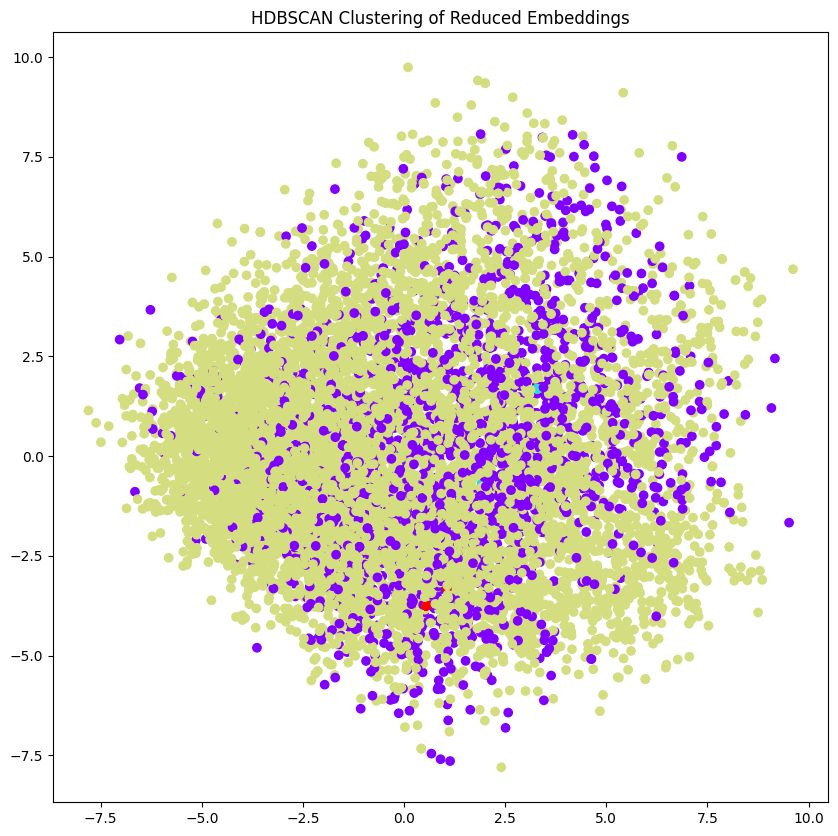

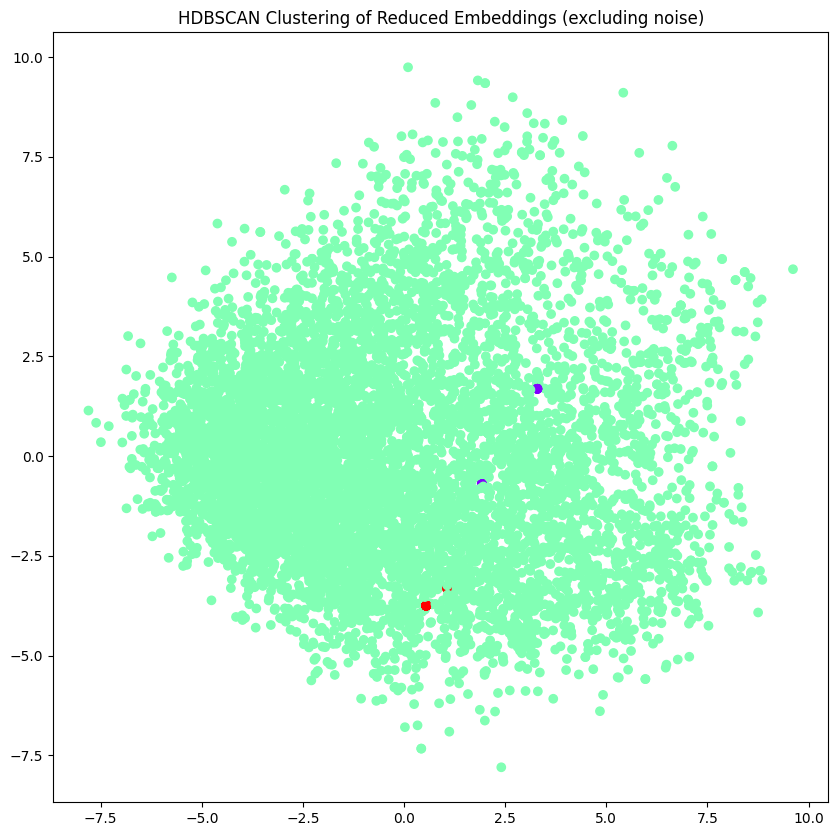

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c = hdbscan_cluster_labels, cmap='rainbow')
plt.title("HDBSCAN Clustering of Reduced Embeddings")
plt.show()

# Mask to exclude noise points (-1)
mask = hdbscan_cluster_labels != -1

plt.figure(figsize=(10,10))
plt.scatter(
    reduced_embeddings[mask, 0],
    reduced_embeddings[mask, 1],
    c=hdbscan_cluster_labels[mask],
    cmap='rainbow',
)
plt.title("HDBSCAN Clustering of Reduced Embeddings (excluding noise)")
plt.show()

In [ ]:
cluster_df.head()

,clean_text,embeddings,kmeans,high_cluster,hdbscan_cluster
0,jpmorgan reels expectations beyond meat,"[0.335539281, -0.858061671, -0.454550415, -0.0...",2,4,1
1,nomura points bookings weakness carnival and r...,"[0.0462081991, -0.772762179, -0.741336942, 0.6...",1,4,-1
2,cemex cut credit suisse morgan weak building o...,"[0.209908009, -0.875504434, 0.181432471, 0.706...",1,0,1
3,btig research cuts neutral,"[0.153301969, -0.837865829, -0.278828889, -0.3...",1,0,1
4,funko slides after piper jaffray cut,"[0.6521855, -1.42149413, -0.86564678, -0.17838...",3,3,-1


In [ ]:
# K-means inertia
print("K-means Inertia:", round(kmeans.inertia_, 1))

# Silhouette scores
print("Silhouette Score (KMeans):", silhouette_score(reduced_embeddings, cluster_df['kmeans']))
print("Silhouette Score (HClust):", silhouette_score(reduced_embeddings, cluster_df['high_cluster']))
mask = cluster_df['hdbscan_cluster'] != -1
sil_hdbscan = silhouette_score(reduced_embeddings[mask], cluster_df['hdbscan_cluster'][mask])
print("Silhouette Score (HDBSCAN, excluding noise):", sil_hdbscan)

# Adjusted Rand Index (pairwise comparisons)
ari_k_h = adjusted_rand_score(cluster_df['kmeans'], cluster_df['hdbscan_cluster'])
ari_k_hc = adjusted_rand_score(cluster_df['kmeans'], cluster_df['high_cluster'])
ari_h_hc = adjusted_rand_score(cluster_df['hdbscan_cluster'], cluster_df['high_cluster'])

print(f"Adjusted Rand Score (KMeans vs HDBSCAN): {ari_k_h:.3f}")
print(f"Adjusted Rand Score (KMeans vs HClust): {ari_k_hc:.3f}")
print(f"Adjusted Rand Score (HDBSCAN vs HClust): {ari_h_hc:.3f}")

K-means Inertia: 954245.1
Silhouette Score (KMeans): 0.055315174173306815
Silhouette Score (HClust): 0.03317246609151681
Silhouette Score (HDBSCAN, excluding noise): 0.17979050532000054
Adjusted Rand Score (KMeans vs HDBSCAN): 0.027
Adjusted Rand Score (KMeans vs HClust): 0.375
Adjusted Rand Score (HDBSCAN vs HClust): 0.017


In [ ]:
import numpy as np
labels = cluster_df["hdbscan_cluster"].to_numpy()

n_noise = np.sum(labels == -1)
noise_pct = n_noise / len(labels) * 100

clusters = sorted(set(labels) - {-1})
print("HDBSCAN clusters (excluding noise):", len(clusters))
print("Noise points:", n_noise, f"({noise_pct:.2f}%)")

# cluster sizes (excluding noise)
for c in clusters:
    print(c, np.sum(labels == c))


HDBSCAN clusters (excluding noise): 3
Noise points: 2033 (21.30%)
0 17
1 7468
2 25
